<a href="https://colab.research.google.com/github/IanSkapin/DataAnalytics/blob/main/modeling-and-visualisation/consolodation/Time_Series_Object_in_Python_bc_edit_10654029874.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Determining p, d, q and P, D, Q

Determining the right order (p, d, q) for ARIMA or SARIMA models (including the seasonal order P, D, Q, m) is typically done through a combination of statistical tests and diagnostic plots. Here's a step-by-step guide from Rob Hynman:


When fitting an ARIMA model to a set of (non-seasonal) time series data, the following procedure provides a useful general approach.

1. Plot the data and identify any unusual observations.
2. If necessary, transform the data (using a Box-Cox transformation) to stabilise the variance.
3. If the data are non-stationary, take first differences of the data until the data are stationary.
4. Examine the ACF/PACF: Is an ARIMA( p,d,0) or ARIMA( 0,d,q) model appropriate?
5. Try your chosen model(s), and use the AICc to search for a better model.
6. Check the residuals from your chosen model by plotting the ACF of the residuals, and doing a portmanteau test of the residuals. If they do not look like white noise, try a modified model.
7. Once the residuals look like white noise, calculate forecasts.

> 🔑 https://otexts.com/fpp3/arima-r.html#modelling-procedure

![image](https://otexts.com/fpp3/figs/arimaflowchart.png)



### Auto-ARIMA (pmdarima)

> 🔑 https://robjhyndman.com/hyndsight/python_time_series.html#pmdarima

> 🔑 https://alkaline-ml.com/pmdarima/

This function will run several seasonal ARIMA models and find the best configuration based on lowest AIC

In [ ]:
! pip install -q pmdarima

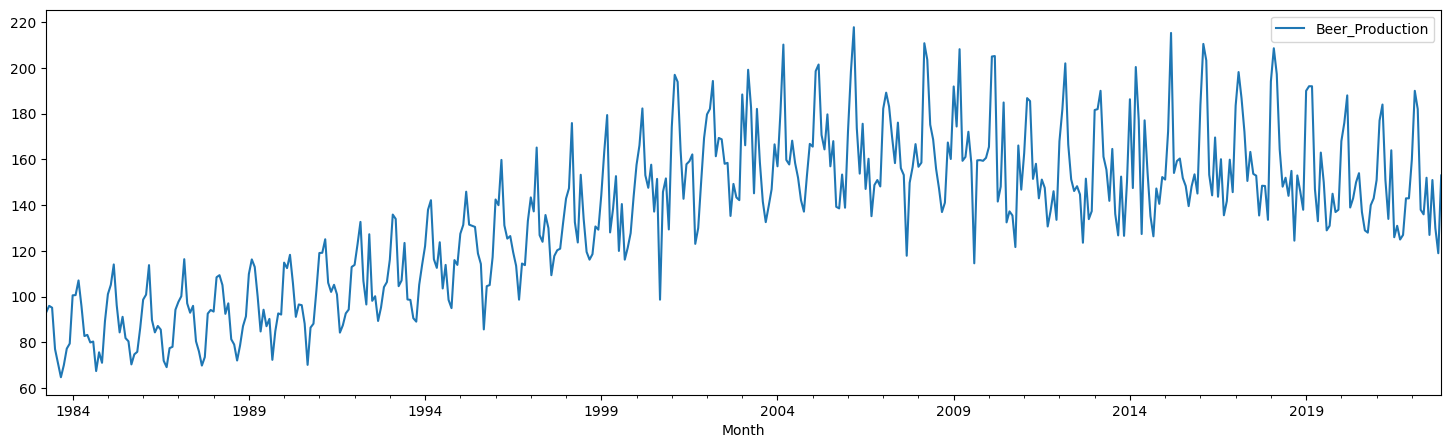

In [ ]:
import pandas as pd
df = pd.read_csv('beer.csv')
df['Month'] = pd.to_datetime(df['Month'], dayfirst=True)
df.set_index('Month',inplace=True)
df.plot(figsize=(18,5));

In [ ]:
df.head()

,Beer_Production
Month,
1983-04-01,93.2
1983-05-01,96.0
1983-06-01,95.2
1983-07-01,77.1
1983-08-01,70.9


In [ ]:
df.tail()

,Beer_Production
Month,
2022-07-01,127.0
2022-08-01,151.0
2022-09-01,130.0
2022-10-01,119.0
2022-11-01,153.0


> 🔑 https://otexts.com/fpp3/long-short-ts.html#forecasting-very-long-time-series

Test for Stationarity

In [ ]:
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(df)

(0.01, False)

'False' means data is non-stationary so we must use the 'Integrated' step in the ARIMA settings

428 48


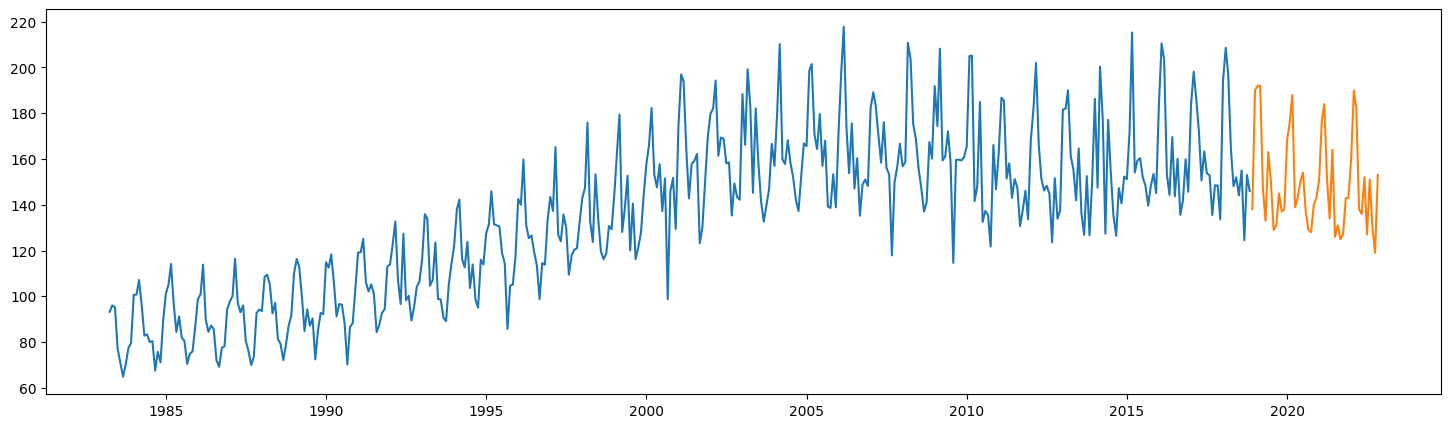

In [ ]:
import matplotlib.pyplot as plt

split = 0.90

size = int(len(df)*split)
df_train = df.iloc[:size]
df_test = df.iloc[size:]
print(len(df_train), len(df_test))
plt.figure(figsize=(18,5))
plt.plot(df_train)
plt.plot(df_test);

In [ ]:
from pmdarima.arima.auto import auto_arima

max_p = 3  # max number of prior y-values to regress against
d = 1  # number of times differencing is applied
max_q = 2  # max number of MA periods considered
m = 12  # period for seasonal differencing

arima_model = auto_arima(
    df_train,
    start_p=0,
    d=1,
    start_q=0,
    max_p=max_p,
    max_d=max_q,
    start_P=0,
    D=1,
    start_Q=0,
    max_P=max_p,
    max_D=d,
    max_Q=max_q,
    m=m,
    seasonal=True,
    error_action='warn',
    trace=True,
    suppress_warnings=True,
    stepwise=True,
    random_state=20)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3605.307, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3432.655, Time=0.56 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3128.942, Time=0.69 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=3277.213, Time=0.24 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=3124.682, Time=1.36 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=3223.623, Time=0.56 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=3123.512, Time=3.38 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=3201.967, Time=1.63 sec
 ARIMA(0,1,1)(3,1,1)[12]             : AIC=3109.970, Time=8.20 sec
 ARIMA(0,1,1)(3,1,0)[12]             : AIC=3168.829, Time=3.55 sec
 ARIMA(0,1,1)(3,1,2)[12]             : AIC=3102.786, Time=11.18 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=3117.209, Time=6.69 sec
 ARIMA(0,1,0)(3,1,2)[12]             : AIC=3377.088, Time=9.91 sec
 ARIMA(1,1,1)(3,1,2)[12]             : AIC=3100.351, Time=13.13 sec
 ARIMA(1,1,1)(2,1

In [ ]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  428
Model:             SARIMAX(2, 1, 1)x(3, 1, [1, 2], 12)   Log Likelihood               -1536.017
Date:                                 Wed, 05 Jul 2023   AIC                           3090.034
Time:                                         07:39:55   BIC                           3126.289
Sample:                                     04-01-1983   HQIC                          3104.371
                                          - 11-01-2018                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1699      0.042     -4.022      0.000      -0.253      -0.087
ar.L2         -0.1888      0.046     -4.079      0.000      -0.280      -0.098
ma.L1         -0.8536      0.027    -31.877      0.000      -0.906      -0.801
ar.S.L12       0.3245      0.158      2.051      0.040       0.014       0.635
ar.S.L24      -0.2415      0.053     -4.527      0.000      -0.346      -0.137
ar.S.L36      -0.2550      0.067     -3.830      0.000      -0.385      -0.125
ma.S.L12      -1.0751      0.157     -6.836      0.000      -1.383      -0.767
ma.S.L24       0.3875      0.131      2.950      0.003       0.130       0.645
sigma2        92.1436      5.197     17.731      0.000      81.958     102.329
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                46.65
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               5.23   Skew:                            -0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
num_periods_ahead = len(df_test)

prediction = pd.DataFrame(arima_model.predict(n_periods=num_periods_ahead),index=df_test.index)
prediction.columns = ['predicted beer production']
prediction

,predicted beer production
Month,
2018-12-01,143.797765
2019-01-01,180.460082
2019-02-01,183.181742
2019-03-01,201.936420
2019-04-01,167.345081
2019-05-01,149.823510
2019-06-01,159.581576
2019-07-01,155.071938
2019-08-01,147.959081


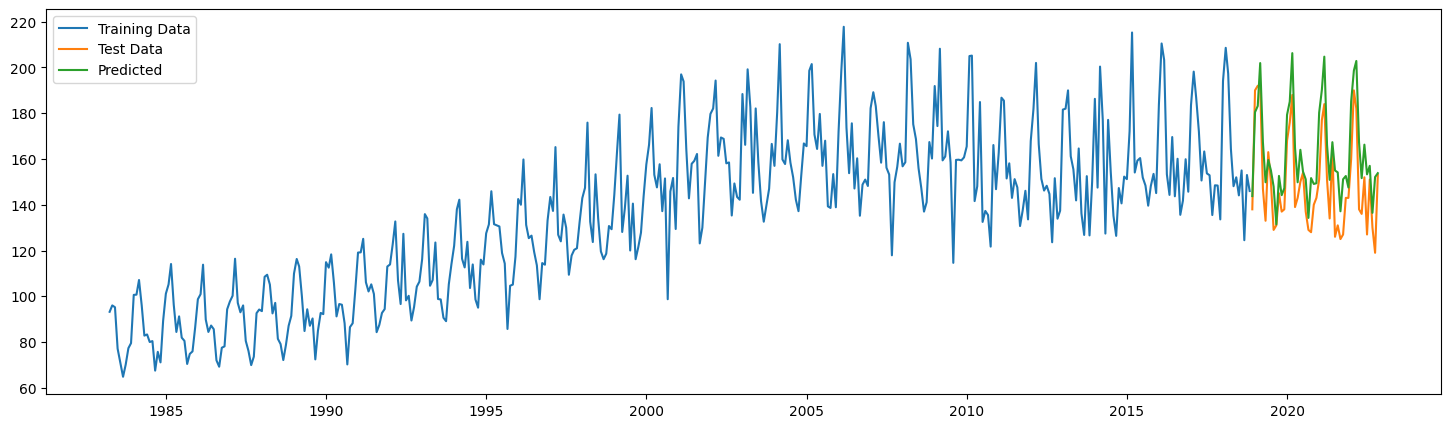

In [ ]:
plt.figure(figsize=(18,5))
plt.plot(df_train, label='Training Data')
plt.plot(df_test, label='Test Data')
plt.plot(prediction, label='Predicted')
plt.legend(loc='upper left');


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(df_test['Beer_Production'], prediction)
rmse = np.sqrt(mean_squared_error(df_test['Beer_Production'], prediction))

print(f'MAE: {mae}, RMSE: {rmse}')


MAE: 13.648966340153548, RMSE: 16.119828541432327


> 🚀 Could also consider cross validation to select model https://alkaline-ml.com/pmdarima/auto_examples/model_selection/example_cross_validation.html

### Neural Network Autoregression Model

We can also look at a Time Series as a Supervised Machine Learning Process...

> https://otexts.com/fpp3/nnetar.html

> *With time series data, lagged values of the time series can be used as inputs to a neural network, just as we used lagged values in a linear autoregression model (Chapter 9). We call this a neural network autoregression or NNAR model.  https://otexts.com/fpp3/nnetar.html#neural-network-autoregression*

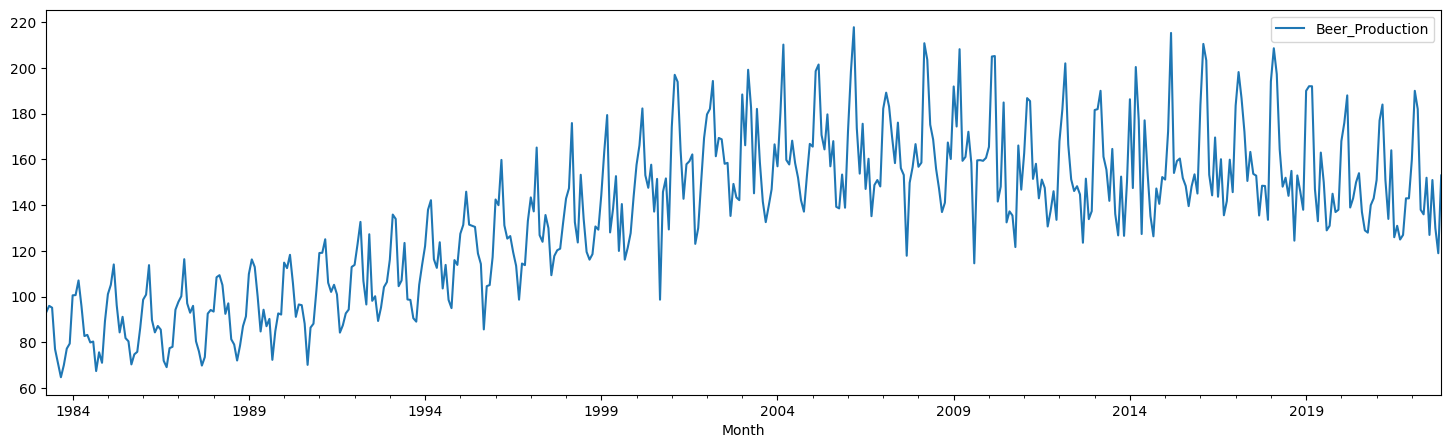

In [ ]:
import pandas as pd
df = pd.read_csv('beer.csv')
df['Month'] = pd.to_datetime(df['Month'], dayfirst=True)
df.set_index('Month',inplace=True)

df.plot(figsize=(18, 5));

In [ ]:
# Shift the 'Beer_Production' series 3 times to create three new time-lagged columns (t-3, t-2, t-1)
# The original 'Beer_Production' series will serve as the current time period (t)
df_SML = pd.concat([df['Beer_Production'].shift(3), df['Beer_Production'].shift(2),
                    df['Beer_Production'].shift(1), df['Beer_Production']], axis=1)

# Rename the columns of the DataFrame to indicate the time-lagged relationships
df_SML.columns = ['t-3', 't-2', 't-1', 't']

# Drop the first three rows which will have NaN values due to the shift operations
df_SML = df_SML.iloc[3:]

# Reset the DataFrame index to start from 0 again after dropping the first three rows
df_SML = df_SML.reset_index(drop=True)

df_SML.head(10)


,t-3,t-2,t-1,t
0,93.2,96.0,95.2,77.1
1,96.0,95.2,77.1,70.9
2,95.2,77.1,70.9,64.8
3,77.1,70.9,64.8,70.1
4,70.9,64.8,70.1,77.3
5,64.8,70.1,77.3,79.5
6,70.1,77.3,79.5,100.6
7,77.3,79.5,100.6,100.7
8,79.5,100.6,100.7,107.1
9,100.6,100.7,107.1,95.9


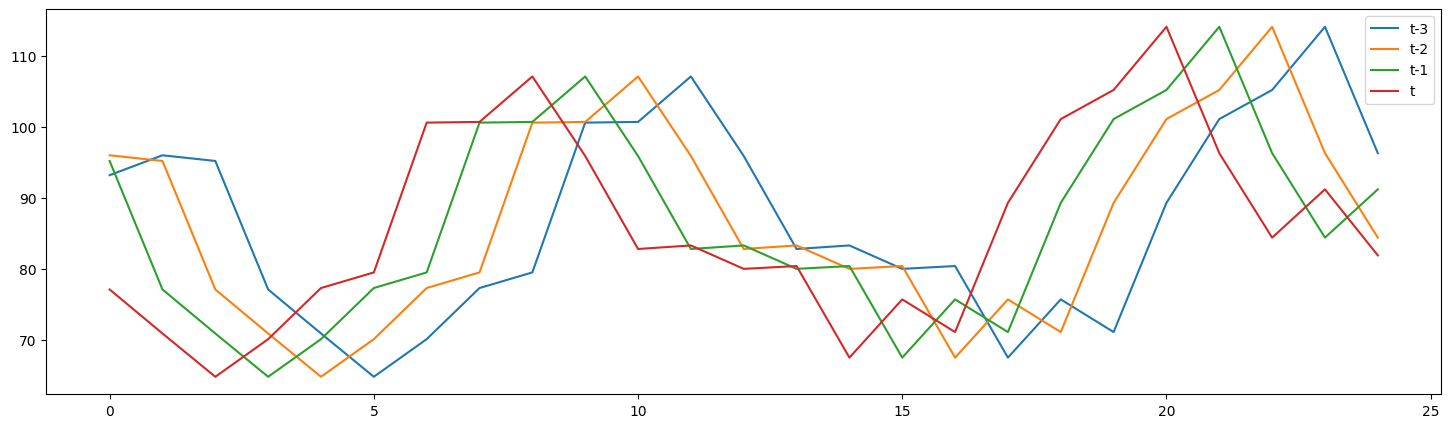

In [ ]:
df_SML.loc[0:24].plot(figsize=(18, 5));


In the table above we can use each previous value of y as a feature in a neural network for instance.

In [ ]:
X = df_SML.drop('t', axis=1)
y = df_SML['t']

In [ ]:
X

,t-3,t-2,t-1
0,93.2,96.0,95.2
1,96.0,95.2,77.1
2,95.2,77.1,70.9
3,77.1,70.9,64.8
4,70.9,64.8,70.1
...,...,...,...
468,138.0,136.0,152.0
469,136.0,152.0,127.0
470,152.0,127.0,151.0
471,127.0,151.0,130.0


In [ ]:
y

0       77.1
1       70.9
2       64.8
3       70.1
4       77.3
       ...  
468    127.0
469    151.0
470    130.0
471    119.0
472    153.0
Name: t, Length: 473, dtype: float64

In [ ]:
from sklearn.model_selection import train_test_split

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
print('Number of training instances:', len(X_train))
print('Number of test instances:', len(y_test))

Number of training instances: 425
Number of test instances: 48


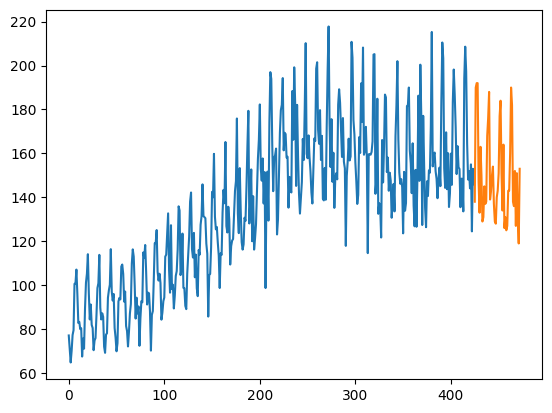

In [ ]:
y_train.plot()
y_test.plot();

In [ ]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model Hyperparameters
neurons = 64
epochs = 200

# Construct the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(neurons, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(neurons/2, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Define the early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model
history = model.fit(X_train, y_train, epochs=epochs, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/200
11/11 [==============================] - 2s 26ms/step - loss: 17854.0156 - val_loss: 25256.4844
Epoch 2/200
11/11 [==============================] - 0s 7ms/step - loss: 17730.0039 - val_loss: 25071.7852
Epoch 3/200
11/11 [==============================] - 0s 8ms/step - loss: 17578.5059 - val_loss: 24837.9551
Epoch 4/200
11/11 [==============================] - 0s 6ms/step - loss: 17346.2461 - val_loss: 24516.5703
Epoch 5/200
11/11 [==============================] - 0s 7ms/step - loss: 17046.9434 - val_loss: 24074.9375
Epoch 6/200
11/11 [==============================] - 0s 8ms/step - loss: 16675.8477 - val_loss: 23489.3770
Epoch 7/200
11/11 [==============================] - 0s 5ms/step - loss: 16154.3672 - val_loss: 22726.0039
Epoch 8/200
11/11 [==============================] - 0s 5ms/step - loss: 15423.6426 - val_loss: 21743.4766
Epoch 9/200
11/11 [==============================] - 0s 6ms/step - loss: 14606.9385 - val_loss: 20540.0996
Epoch 10/200
11/11 [================

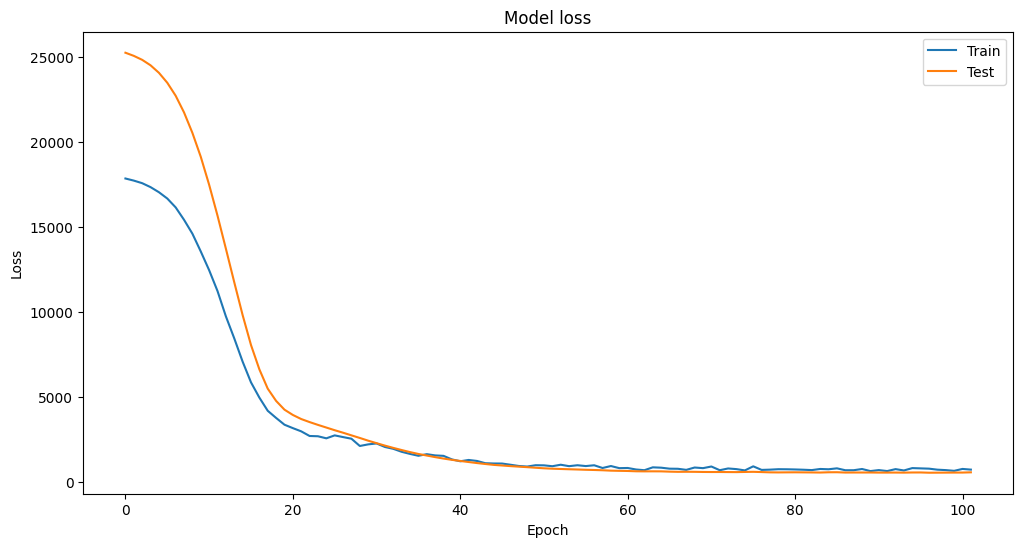

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()


2/2 [==============================] - 0s 9ms/step
Test RMSE: 21.181971360988946
Test MAE: 17.26080322265625


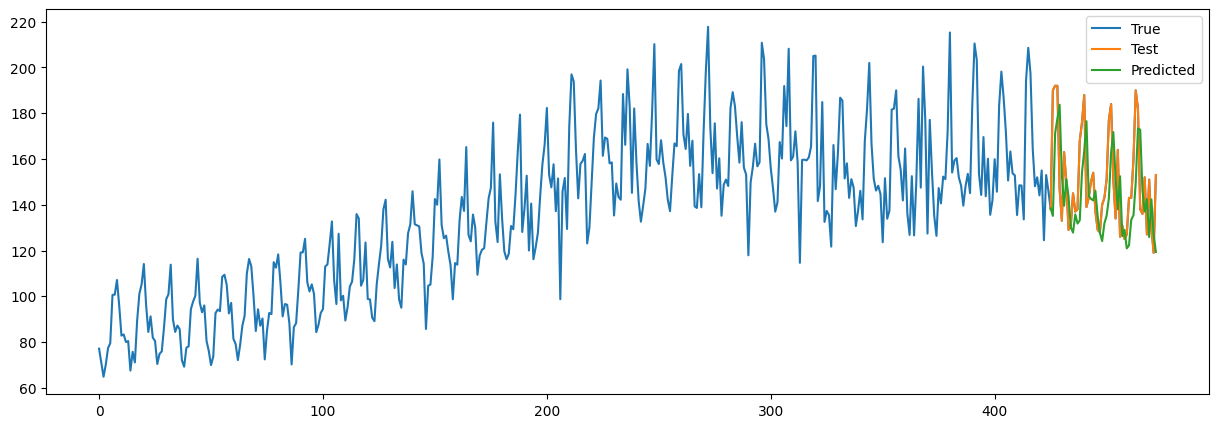

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Generate predictions and calculate metrics
y_pred = model.predict(X_test)
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('Test MAE:', mean_absolute_error(y_test, y_pred))

# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(y, label='True')  # Plot the entire true series
plt.plot(np.arange(len(y_train), len(y)), y_test, label='Test')  # Plot the test part of the true series
plt.plot(np.arange(len(y_train), len(y)), y_pred, label='Predicted')  # Plot the predictions for the test part
plt.legend();


### Facebook's Prophet

The following Time Series Forecasts are made using Facebook's Open Source Prophet Model on the Beer Production series...

> 🔑 https://facebook.github.io/prophet/docs/quick_start.html#python-api

> 🔑 https://otexts.com/fpp3/prophet.html

In [ ]:
!pip install -q prophet

In [ ]:
import datetime
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

df = pd.read_csv('beer.csv')
df['Month'] = pd.to_datetime(df['Month'], dayfirst=True)
df['ds'] = df['Month']
df['y'] = df['Beer_Production']
df = df.drop(columns=['Beer_Production','Month'])

df = df.iloc[1:]
df.tail(3)

,ds,y
473,2022-09-01,130.0
474,2022-10-01,119.0
475,2022-11-01,153.0


In [ ]:
# Split the data into train and test
train_size = int(len(df) * 0.9)  # Use 90% of data for training
df_train = df.iloc[:train_size]
df_test = df.iloc[train_size:]

df_train

,ds,y
1,1983-05-01,96.0
2,1983-06-01,95.2
3,1983-07-01,77.1
4,1983-08-01,70.9
5,1983-09-01,64.8
...,...,...
423,2018-07-01,144.1
424,2018-08-01,155.0
425,2018-09-01,124.5
426,2018-10-01,153.0


In [ ]:
model = Prophet()
model.fit(df_train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2w4a2zva/t0pr2e86.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2w4a2zva/ub2vndue.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31316', 'data', 'file=/tmp/tmp2w4a2zva/t0pr2e86.json', 'init=/tmp/tmp2w4a2zva/ub2vndue.json', 'output', 'file=/tmp/tmp2w4a2zva/prophet_model3v091ryr/prophet_model-20230705075553.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:55:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:55:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Absolute Error on Test Set: 11.922367390564064
Root Mean Squared Error on Test Set: 14.101092468893958


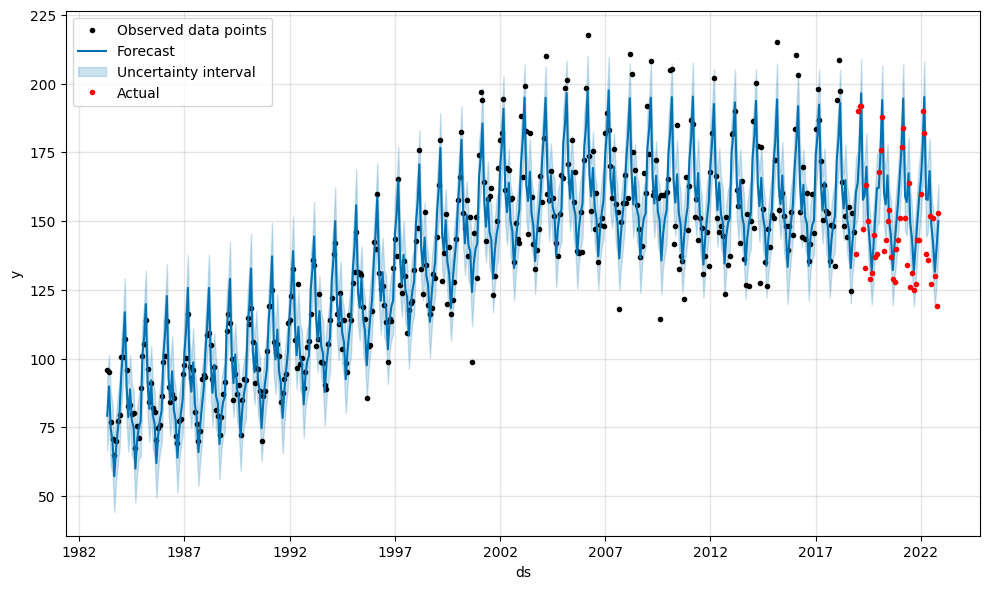

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Predict on the test set
future = model.make_future_dataframe(len(df_test), freq='M')
forecast = model.predict(future)

# Calculate MAE between the forecasted and actual values
mae = mean_absolute_error(df_test['y'], forecast['yhat'][-len(df_test):])
print('Mean Absolute Error on Test Set:', mae)

# Calculate RMSE between the forecasted and actual values
rmse = np.sqrt(mean_squared_error(df_test['y'], forecast['yhat'][-len(df_test):]))
print('Root Mean Squared Error on Test Set:', rmse)

model.plot(forecast)
plt.plot(df_test['ds'], df_test['y'], '.r', label='Actual')
plt.legend()


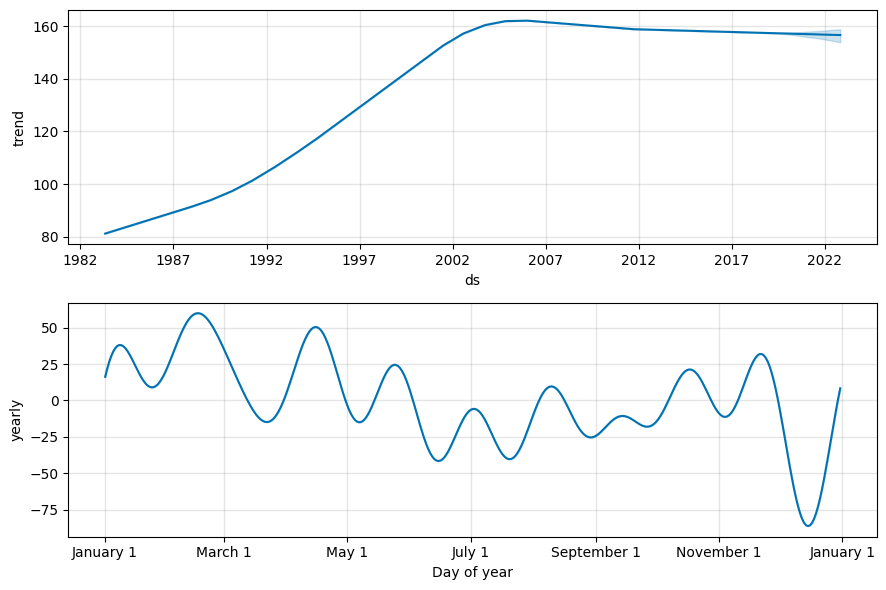

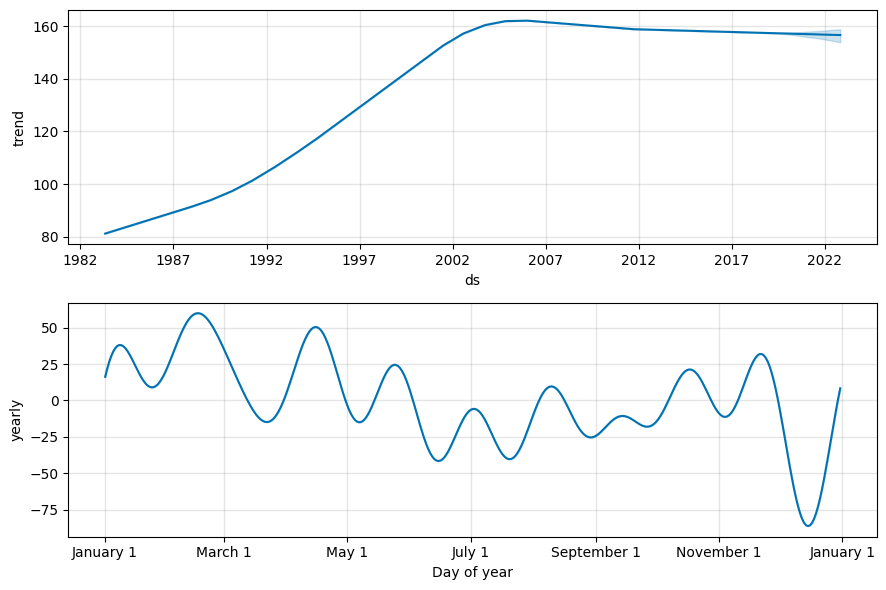

In [ ]:
# Plot the model forecast chart with component charts in trend and seasonality
model.plot_components(forecast)


### PyCaret

In [ ]:
!pip install -q pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.4/484.4 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 81.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

https://pycaret.gitbook.io/docs/get-started/tutorials

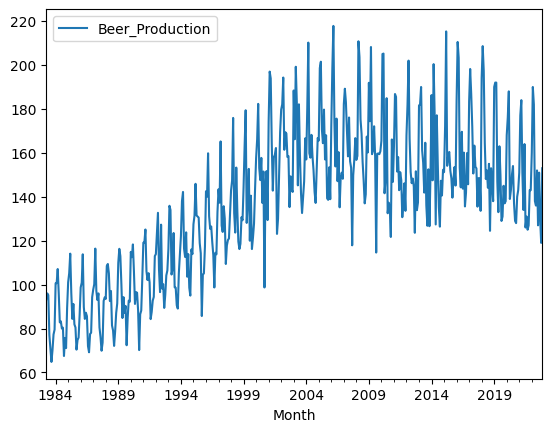

In [ ]:
import pandas as pd
df = pd.read_csv('beer.csv')
df['Month'] = pd.to_datetime(df['Month'], dayfirst=True)
df.set_index('Month',inplace=True)
df.plot();

https://pycaret.readthedocs.io/en/latest/api/time_series.html#pycaret.time_series.setup

https://robjhyndman.com/hyndsight/python_time_series.html#sktime

In [ ]:
# import pycaret time series and init setup
from pycaret.time_series import *
s = setup(df, fh = 48, session_id = 123)

,Description,Value
0,session_id,123
1,Target,Beer_Production
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(476, 1)"
5,Transformed data shape,"(476, 1)"
6,Transformed train set shape,"(428, 1)"
7,Transformed test set shape,"(48, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [ ]:
dir(s)

['USI',
 'X',
 'X_test',
 'X_test_transformed',
 'X_train',
 'X_train_transformed',
 'X_transformed',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_feat_eng_steps',
 '_add_imputation_steps',
 '_add_scaling_steps',
 '_add_transformation_steps',
 '_all_metrics',
 '_all_models',
 '_all_models_internal',
 '_attributes_to_not_save',
 '_available_plots',
 '_available_plots_data_keys',
 '_available_plots_estimator_keys',
 '_calculate_metrics',
 '_check_and_clean_index',
 '_check_and_clean_resid',
 '_check_and_set_fh',
 '_check_and_set_forecasting_types',
 '_check_and_set_seasonal_period',
 '_check_and_set_targets',
 '_check_clean_and_set_data',
 '_che

<Axes: xlabel='Month'>

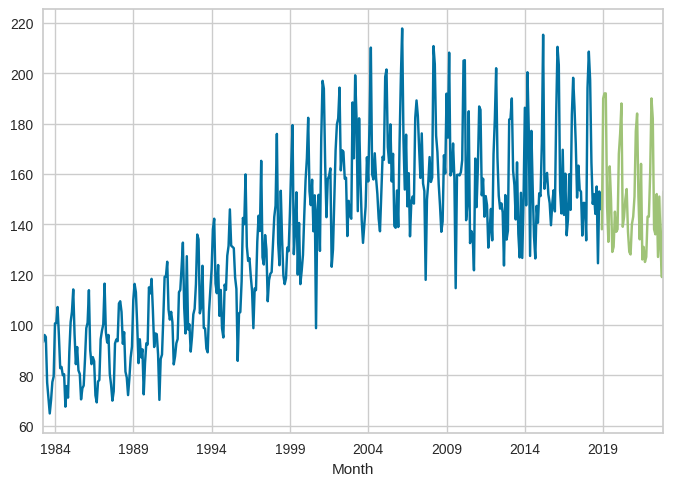

In [ ]:
s.y_train.plot()
s.y_test.plot()

In [ ]:
# check statistical tests on original data
check_stats()

,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,476.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,136.395378
3,Summary,Statistics,Transformed,Median,,139.15
4,Summary,Statistics,Transformed,Standard Deviation,,33.738725
5,Summary,Statistics,Transformed,Variance,,1138.301536
6,Summary,Statistics,Transformed,Kurtosis,,-0.61576
7,Summary,Statistics,Transformed,Skewness,,-0.035923
8,Summary,Statistics,Transformed,# Distinct Values,,383.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",5233.042327


In [ ]:
# compare baseline models
best = compare_models()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
auto_arima,Auto ARIMA,1.1408,1.1085,9.5559,12.5178,0.0618,0.0601,0.6554,265.9800
ets,ETS,1.2172,1.1886,10.2967,13.5424,0.0658,0.0647,0.6052,0.3800
theta,Theta Forecaster,1.3361,1.2980,11.2673,14.7402,0.0740,0.0702,0.5177,0.0700
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,1.3655,1.3229,11.3931,14.8636,0.0758,0.0714,0.5025,1.9400
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,1.3655,1.3229,11.3932,14.8637,0.0758,0.0714,0.5024,2.2200
exp_smooth,Exponential Smoothing,1.3745,1.3251,11.5042,14.9434,0.0739,0.0714,0.5065,1.0933
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,1.3828,1.3412,11.5421,15.0800,0.0770,0.0724,0.4887,1.4433
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,1.3957,1.3555,11.6535,15.2478,0.0779,0.0731,0.4777,1.4733
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,1.3957,1.3555,11.6537,15.2481,0.0779,0.0731,0.4777,1.4667
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,1.4146,1.3733,11.8310,15.4715,0.0791,0.0742,0.4654,1.4667


Processing:   0%|          | 0/117 [00:00<?, ?it/s]

In [ ]:
# create the auto_arima model to see the p,d,q... etc... values
model = create_model('auto_arima')
print(model)


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2006-11,1.6095,1.5961,12.3480,16.3830,0.0820,0.0770,0.4689
1,2010-11,0.9351,0.8729,8.2742,10.5370,0.0552,0.0541,0.7365
2,2014-11,0.8777,0.8565,8.0456,10.6333,0.0483,0.0492,0.7608
Mean,NaT,1.1408,1.1085,9.5559,12.5178,0.0618,0.0601,0.6554
SD,NaT,0.3322,0.3448,1.9765,2.7334,0.0146,0.0121,0.1322


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

AutoARIMA(random_state=123, sp=12, suppress_warnings=True)


In [ ]:
# Print the model summary
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  428
Model:             SARIMAX(5, 1, 4)x(1, 0, [1], 12)   Log Likelihood               -1555.327
Date:                              Wed, 05 Jul 2023   AIC                           3134.654
Time:                                      09:08:15   BIC                           3183.335
Sample:                                  04-30-1983   HQIC                          3153.882
                                       - 11-30-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2383      0.067     -3.567      0.000      -0.369      -0.107
ar.L2         -0.1540      0.072     -2.138      0.033      -0.295      -0.013
ar.L3          0.6925      0.077      9.020      0.000       0.542       0.843
ar.L4         -0.1717      0.053     -3.234      0.001      -0.276      -0.068
ar.L5          0.0297      0.053      0.562      0.574      -0.074       0.134
ma.L1         -0.7200      0.050    -14.350      0.000      -0.818      -0.622
ma.L2         -0.1459      0.032     -4.533      0.000      -0.209      -0.083
ma.L3         -0.7976      0.031    -25.692      0.000      -0.858      -0.737
ma.L4          0.8144      0.045     18.226      0.000       0.727       0.902
ar.S.L12       0.9937      0.005    200.917      0.000       0.984       1.003
ma.S.L12      -0.8067      0.040    -20.193      0.000      -0.885      -0.728
sigma2        78.1173      4.244     18.405      0.000      69.798      86.436
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                69.23
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               4.64   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# plot forecast
plot_model(model, plot = 'forecast')

In [ ]:
# check_stats on residuals of best model
check_stats(estimator = model)

,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Residual,Length,,427.0
1,Summary,Statistics,Residual,# Missing Values,,0.0
2,Summary,Statistics,Residual,Mean,,-0.057333
3,Summary,Statistics,Residual,Median,,-0.0359
4,Summary,Statistics,Residual,Standard Deviation,,9.265913
5,Summary,Statistics,Residual,Variance,,85.857145
6,Summary,Statistics,Residual,Kurtosis,,1.639302
7,Summary,Statistics,Residual,Skewness,,-0.248232
8,Summary,Statistics,Residual,# Distinct Values,,427.0
9,White Noise,Ljung-Box,Residual,Test Statictic,"{'alpha': 0.05, 'K': 24}",20.722759


In [ ]:
compare_ts_models = compare_models(include = ['ets', 'arima', 'theta', 'naive', 'snaive', 'grand_means', 'polytrend'])

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
ets,ETS,1.2172,1.1886,10.2967,13.5424,0.0658,0.0647,0.6052,2.8067
theta,Theta Forecaster,1.3361,1.2980,11.2673,14.7402,0.0740,0.0702,0.5177,0.0533
snaive,Seasonal Naive Forecaster,1.8786,1.7542,16.0687,20.3303,0.1025,0.1017,0.0864,0.1100
arima,ARIMA,2.0284,1.9071,17.3151,21.9801,0.1119,0.1062,-0.0648,0.1733
naive,Naive Forecaster,2.4259,2.2689,20.7076,26.1732,0.1268,0.1299,-0.4813,0.0633
polytrend,Polynomial Trend Forecaster,3.3999,2.8858,29.1777,33.4257,0.1983,0.1751,-1.4780,0.0333
grand_means,Grand Means Forecaster,3.8526,3.3953,32.3428,38.6155,0.1890,0.2163,-2.2158,0.0400


Processing:   0%|          | 0/33 [00:00<?, ?it/s]

In [ ]:
compare_ts_models

AutoETS(seasonal='mul', sp=12, trend='add')

In [ ]:
# check_stats on residuals of best model
check_stats(estimator = compare_ts_models)

,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Residual,Length,,428.0
1,Summary,Statistics,Residual,# Missing Values,,0.0
2,Summary,Statistics,Residual,Mean,,-0.031941
3,Summary,Statistics,Residual,Median,,0.812
4,Summary,Statistics,Residual,Standard Deviation,,9.588882
5,Summary,Statistics,Residual,Variance,,91.946651
6,Summary,Statistics,Residual,Kurtosis,,1.408445
7,Summary,Statistics,Residual,Skewness,,-0.307641
8,Summary,Statistics,Residual,# Distinct Values,,428.0
9,White Noise,Ljung-Box,Residual,Test Statictic,"{'alpha': 0.05, 'K': 24}",218.540809


In [ ]:
# plot forecast
plot_model(compare_ts_models, plot = 'forecast')

In [ ]:
final_best = finalize_model(compare_ts_models)

In [ ]:
final_best

ForecastingPipeline(steps=[('forecaster',
                            TransformedTargetForecaster(steps=[('model',
                                                                AutoETS(seasonal='mul',
                                                                        sp=12,
                                                                        trend='add'))]))])

In [ ]:
# plot forecast
plot_model(final_best, plot = 'forecast')

## Nixtla

> 🔑 https://robjhyndman.com/hyndsight/python_time_series.html#nixtla

> 🔑 https://nixtla.github.io/statsforecast/docs/how-to-guides/autoarima_vs_prophet.html

> 🔑 https://nixtla.github.io/statsforecast/docs/getting-started/getting_started_complete.html

In [ ]:
!pip install -q statsforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.6/273.6 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.6/154.6 kB 15.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.6/279.6 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 12.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import datetime
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

df = pd.read_csv('beer.csv')
df['Month'] = pd.to_datetime(df['Month'], dayfirst=True)
df['ds'] = df['Month']
df['y'] = df['Beer_Production']
df = df.drop(columns=['Beer_Production','Month'])

df = df.iloc[1:]
df.tail(3)

,ds,y
473,2022-09-01,130.0
474,2022-10-01,119.0
475,2022-11-01,153.0


In [ ]:
# statsoforecast can run on multiple time series at once, we only have one time series so we give it the same id of 1
df['unique_id']=1
df

,ds,y,unique_id
1,1983-05-01,96.0,1
2,1983-06-01,95.2,1
3,1983-07-01,77.1,1
4,1983-08-01,70.9,1
5,1983-09-01,64.8,1
...,...,...,...
471,2022-07-01,127.0,1
472,2022-08-01,151.0,1
473,2022-09-01,130.0,1
474,2022-10-01,119.0,1


In [ ]:
import statsforecast

from statsforecast.models import (
    AutoARIMA,
    HoltWinters,
    CrostonClassic as Croston,
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive
)


# Create a list of models and instantiation parameters
models = [
    AutoARIMA(season_length=12),
    HoltWinters(),
    Croston(),
    SeasonalNaive(season_length=12),
    HistoricAverage(),
    DOT(season_length=12)
]

In [ ]:
from statsforecast import StatsForecast # required to instantiate StastForecast object and use cross-validation method

# Instantiate StatsForecast class as sf
sf = StatsForecast(
    df=df,
    models=models,
    freq='MS',
    n_jobs=-1,
    fallback_model = SeasonalNaive(season_length=7)
)

In [ ]:
forecasts_df = sf.forecast(h=48, level=[90])

forecasts_df.head()

,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,HoltWinters,HoltWinters-lo-90,HoltWinters-hi-90,CrostonClassic,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90,HistoricAverage,HistoricAverage-lo-90,HistoricAverage-hi-90,DynamicOptimizedTheta,DynamicOptimizedTheta-lo-90,DynamicOptimizedTheta-hi-90
unique_id,,,,,,,,,,,,,,,,,
1,2022-12-01,136.695557,120.696358,152.694763,136.0,-3.23569,275.235687,144.53772,143.0,101.921425,184.078568,136.486328,80.970345,192.002304,144.172150,130.077682,161.949722
1,2023-01-01,161.766510,145.724274,177.808746,152.0,12.76431,291.235687,144.53772,160.0,118.921425,201.078568,136.486328,80.970345,192.002304,165.387238,146.674438,180.892426
1,2023-02-01,181.552979,165.341141,197.764801,127.0,-12.23569,266.235687,144.53772,190.0,148.921432,231.078568,136.486328,80.970345,192.002304,175.100693,151.587555,193.546005
1,2023-03-01,185.917480,169.592697,202.242279,151.0,11.76431,290.235687,144.53772,182.0,140.921432,223.078568,136.486328,80.970345,192.002304,188.018906,166.918594,205.732330
1,2023-04-01,146.094086,129.657135,162.531052,130.0,-9.23569,269.235687,144.53772,138.0,96.921425,179.078568,136.486328,80.970345,192.002304,154.826157,140.374420,173.167923


https://stackoverflow.com/questions/75290492/how-to-get-model-specification-paramters-for-models-estimated-with-nixtlas-stat

In [ ]:
sf.models

[AutoARIMA,
 HoltWinters,
 CrostonClassic,
 SeasonalNaive,
 HistoricAverage,
 DynamicOptimizedTheta]

In [ ]:
dir(sf.models[0])

['D',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'alias',
 'allowdrift',
 'allowmean',
 'approximation',
 'biasadj',
 'blambda',
 'd',
 'fit',
 'forecast',
 'forward',
 'ic',
 'max_D',
 'max_P',
 'max_Q',
 'max_d',
 'max_order',
 'max_p',
 'max_q',
 'method',
 'new',
 'nmodels',
 'num_cores',
 'parallel',
 'predict',
 'predict_in_sample',
 'season_length',
 'seasonal',
 'seasonal_test',
 'seasonal_test_kwargs',
 'start_P',
 'start_Q',
 'start_p',
 'start_q',
 'stationary',
 'stepwise',
 'test',
 'test_kwargs',
 'trace',
 'truncate']

In [ ]:
p = sf.models[0].max_p
d = sf.models[0].max_d
q = sf.models[0].max_q

print('p:', p)
print('d:', d)
print('q:', q)


p: 5
d: 2
q: 5


In [ ]:
sf.plot(df,forecasts_df)

In [ ]:
# Explore other models
sf.plot(df, forecasts_df, models=["AutoARIMA"], level=[90])

In [ ]:
# Explore other models
sf.plot(df, forecasts_df, models=["HoltWinters"], level=[90])

### Cross validation

> 🔑 https://otexts.com/fpp3/tscv.html

![cvfh](https://otexts.com/fpp3/fpp_files/figure-html/cv1-1.png)

> *Image from https://otexts.com/fpp3/tscv.html*

> 🔑 https://nixtla.github.io/statsforecast/docs/tutorials/crossvalidation.html

> 🔑 https://nixtla.github.io/statsforecast/docs/getting-started/getting_started_complete.html#evaluate-the-models-performance



![cv](https://raw.githubusercontent.com/Nixtla/statsforecast/main/nbs/imgs/ChainedWindows.gif)

> Image from https://nixtla.github.io/statsforecast/docs/getting-started/getting_started_complete.html#evaluate-the-models-performance

In [ ]:
crossvaldation_df = sf.cross_validation(
    df=df,
    h=24,
    step_size=12,
    n_windows=5
  )

In [ ]:
crossvaldation_df.head()

,ds,cutoff,y,AutoARIMA,HoltWinters,CrostonClassic,SeasonalNaive,HistoricAverage,DynamicOptimizedTheta
unique_id,,,,,,,,,
1,2016-12-01,2016-11-01,145.699997,150.689789,144.300003,157.431122,145.100006,133.491821,159.369736
1,2017-01-01,2016-11-01,183.500000,178.274506,169.600006,157.431122,183.699997,133.491821,180.299026
1,2017-02-01,2016-11-01,198.199997,188.900436,143.699997,157.431122,210.500000,133.491821,189.753540
1,2017-03-01,2016-11-01,186.800003,203.009521,160.100006,157.431122,203.300003,133.491821,206.850800
1,2017-04-01,2016-11-01,172.000000,165.957092,135.600006,157.431122,153.300003,133.491821,171.020248


In [ ]:
crossvaldation_df[['cutoff']].value_counts()

cutoff    
2016-11-01    24
2017-11-01    24
2018-11-01    24
2019-11-01    24
2020-11-01    24
dtype: int64

In [ ]:
df_long = crossvaldation_df.melt(id_vars=['ds', 'cutoff'], value_vars=['y', 'AutoARIMA'],
                                 var_name='variable', value_name='value')
df_long


,ds,cutoff,variable,value
0,2016-12-01,2016-11-01,y,145.699997
1,2017-01-01,2016-11-01,y,183.500000
2,2017-02-01,2016-11-01,y,198.199997
3,2017-03-01,2016-11-01,y,186.800003
4,2017-04-01,2016-11-01,y,172.000000
...,...,...,...,...
235,2022-07-01,2020-11-01,AutoARIMA,141.230637
236,2022-08-01,2020-11-01,AutoARIMA,135.306595
237,2022-09-01,2020-11-01,AutoARIMA,122.051857
238,2022-10-01,2020-11-01,AutoARIMA,134.864120


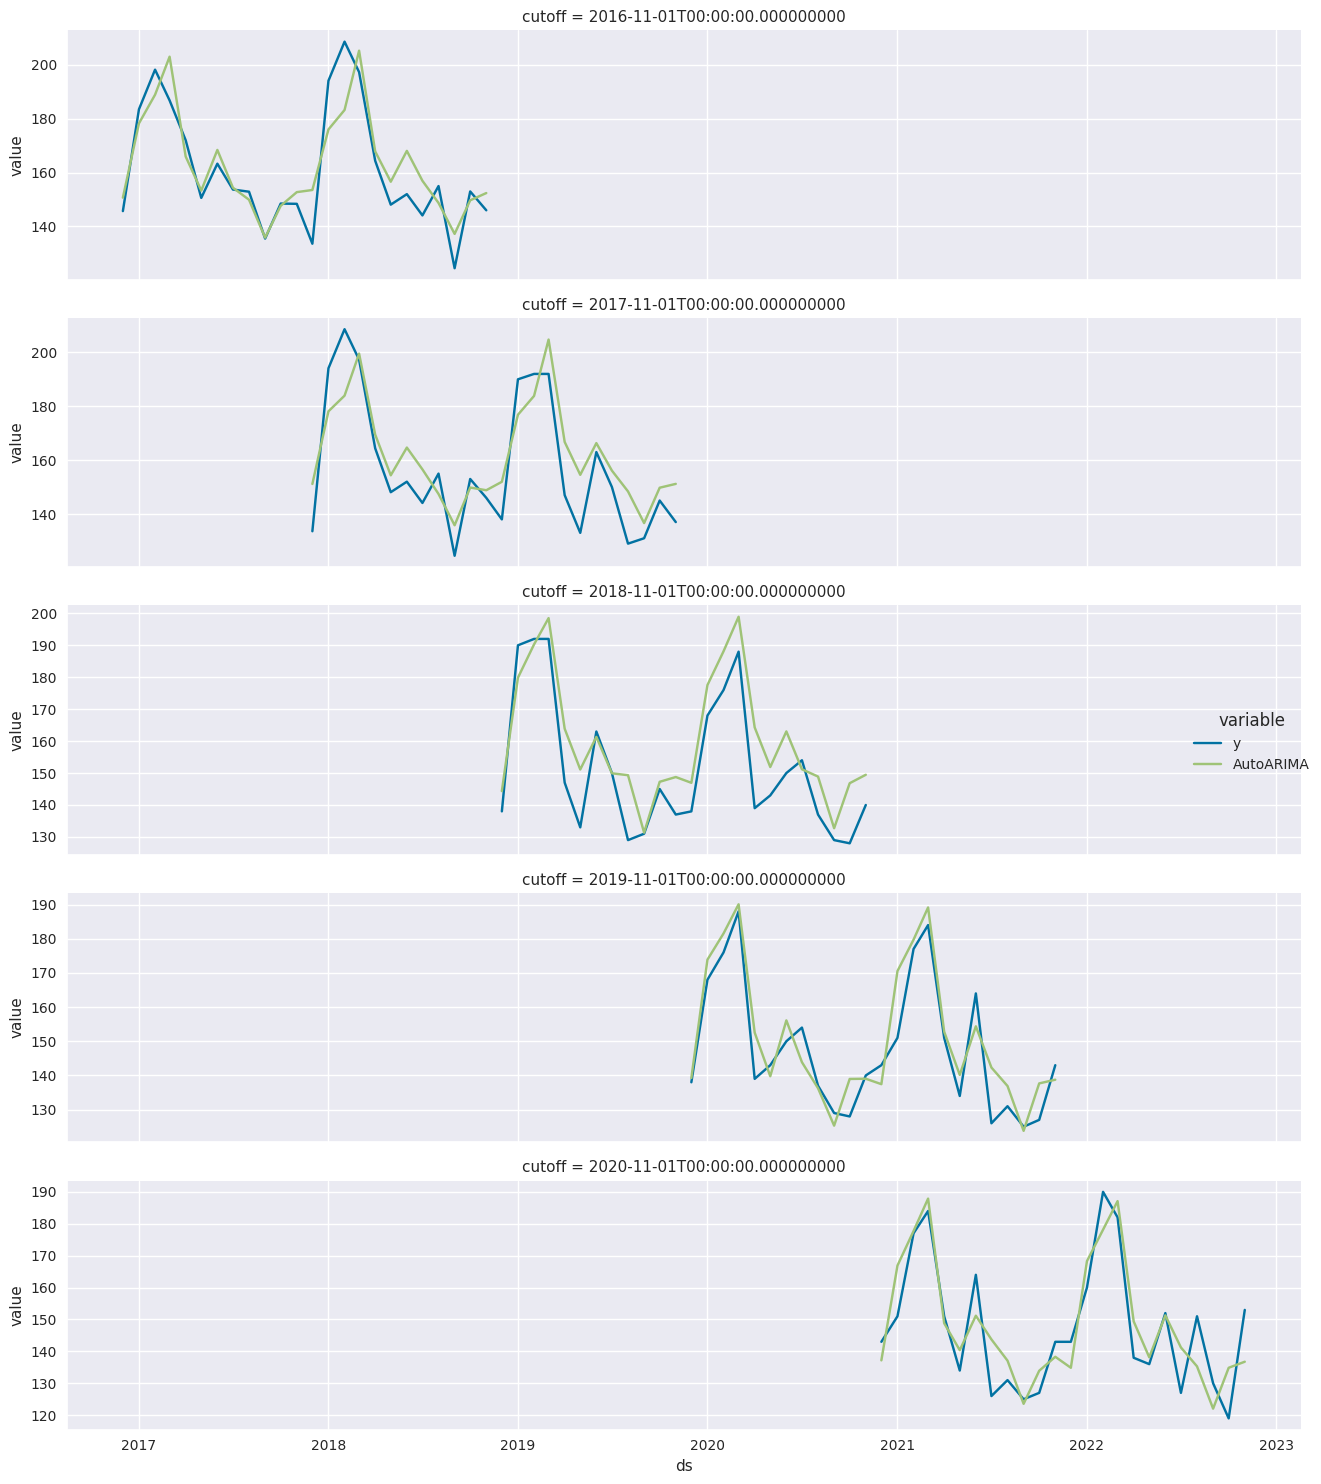

In [ ]:
import seaborn as sns
sns.set_style('darkgrid')

g = sns.FacetGrid(df_long, row='cutoff', hue='variable', aspect=4, height=3, sharey=False)
g.map(sns.lineplot, 'ds', 'value')

g.add_legend()  # Add a legend
plt.tight_layout()
plt.show()


In [ ]:
!pip install -q datasetsforecast

In [ ]:
from datasetsforecast.losses import mse, mae, rmse

def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    for model in models:
        eval_ = df.groupby(['unique_id', 'cutoff']).apply(lambda x: metric(x['y'].values, x[model].values)).to_frame() # Calculate loss for every unique_id, model and cutoff.
        eval_.columns = [model]
        evals.append(eval_)
    evals = pd.concat(evals, axis=1)
    evals = evals.groupby(['unique_id']).mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals

In [ ]:
evaluation_df = evaluate_cross_validation(crossvaldation_df, rmse)

evaluation_df.head()

,AutoARIMA,HoltWinters,CrostonClassic,SeasonalNaive,HistoricAverage,DynamicOptimizedTheta,best_model
unique_id,,,,,,,
1,10.617566,23.044807,21.424669,12.136564,28.095133,13.066152,AutoARIMA


> 🚀 https://nixtla.github.io/statsforecast/docs/tutorials/statisticalneuralmethods.html

> 🔑 https://nixtla.github.io/statsforecast/docs/tutorials/statisticalneuralmethods.html#mlforecast and https://nixtla.github.io/mlforecast/

> 🔑 https://nixtla.github.io/statsforecast/docs/tutorials/statisticalneuralmethods.html#neuralforecast and https://nixtla.github.io/neuralforecast/